# PINN for solving Heat equation

$$
\frac{\partial u}{\partial t}  = \alpha\frac{\partial^2 u}{\partial x^2}
$$

N-Wave type solution with starting temperature profile being 

$$
u(x,0) = \cdot\mathrm{e}^{x^2/2}
$$
with $\alpha = 2.0$

In [1]:
import tensorflow as tf
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100  
plt.ioff()

In [2]:
class NN(tf.keras.Model):
    def __init__(
            self, 
            num_inputs: int=1,
            num_hidden_layers: int=1,
            num_neurons: int=1,
            activation: str = 'tanh'
    )->None:
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons

        NNLayers = []
        for _ in range(num_hidden_layers):
            NNLayers.append(tf.keras.layers.Dense(units=num_neurons, activation=activation)) # the hidden layers
        NNLayers.append(tf.keras.layers.Dense(units=1)) # the output layer

        self.NNLayers = NNLayers

    def call(
            self,
            input: tf.Tensor
    )->tf.Tensor: # the neural network call implements the forward call, where it runs the input through the first layer, and then feeds the output of the first layer to the second layer and so on
        output = tf.reshape(input, shape=(-1, self.num_inputs))
        for layer in self.NNLayers:
            output = layer(output)
        return output


In [3]:
NUM_LAYERS = 7
NUM_NEURONS = 7
EPOCHS = 50000 #how many times the training step is performed
BATCH_SIZE = 100 # how many input values are considered for each epoch
LEARNING_RATE = 1e-3
TOLERANCE = 2e-5
NUM_INPUTS = 2

a = 2.0

T_DOMAIN = (0.0, 5.0)
X_DOMAIN = (0.0, 10.0)
T_BOUNDARY = tf.concat([tf.linspace(X_DOMAIN[0], X_DOMAIN[1], BATCH_SIZE)[:, tf.newaxis], tf.fill([BATCH_SIZE,1], T_DOMAIN[0])], axis=1)

def loss(
        model: tf.keras.Model, 
        xt: tf.Tensor
)-> tf.Tensor:
    x = tf.gather(xt, [0], axis=1)
    t = tf.gather(xt, [1], axis=1)

    with tf.GradientTape(persistent=True) as tape: # required in order to calculate the derivatives
        tape.watch(x)
        tape.watch(t)
        u = model(tf.concat([x,t], axis=1))
        u_x = tape.gradient(u, x)

    u_xx = tape.gradient(u_x, x) 
    u_t = tape.gradient(u, t)

    de = u_t - a*u_xx

    t_boundary_xvals = tf.gather(T_BOUNDARY, [0], axis=1)
    boundary_x_0 = model(T_BOUNDARY) - tf.exp(-tf.square(t_boundary_xvals)/2.0) 

    loss_val = tf.reduce_mean(tf.square(de)) + tf.reduce_mean(tf.square(boundary_x_0))

    return loss_val 



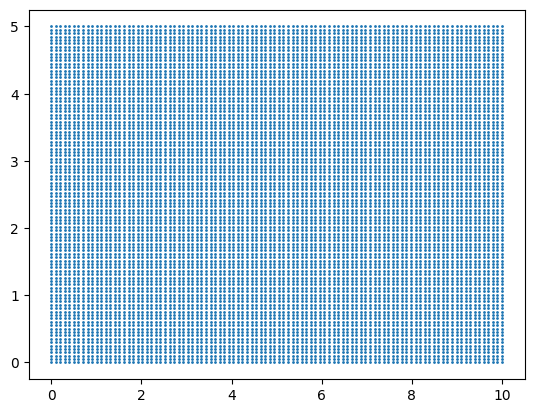

In [4]:
x_plot = tf.linspace(X_DOMAIN[0], X_DOMAIN[1], BATCH_SIZE)[:, tf.newaxis]
t_plot = tf.linspace(T_DOMAIN[0], T_DOMAIN[1], BATCH_SIZE)[:, tf.newaxis]
X_mesh, T_mesh = tf.meshgrid(x_plot, t_plot)
X_pred = tf.reshape(X_mesh, shape=(-1, 1))
T_pred = tf.reshape(T_mesh, shape=(-1, 1))

plt.scatter(X_pred, T_pred, s=1)
plt.show()

In [5]:
INPUT = tf.concat([X_pred, T_pred], axis=1)

model = NN(num_inputs=NUM_INPUTS, num_hidden_layers= NUM_LAYERS, num_neurons=NUM_NEURONS)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

@tf.function
def train_step(model, input): # function for one single training step
    with tf.GradientTape(persistent=True) as tape:
        loss_val = loss(model, input)

    gradient = tape.gradient(loss_val, model.trainable_variables) # calculate the gradients of the loss with respect to \theta
    optimizer.apply_gradients(zip(gradient, model.trainable_variables)) # optimize the parameters to minimize the loss

    return loss_val

for epoch in range(EPOCHS):
    # input_batch = tf.keras.random.uniform(shape=(BATCH_SIZE, NUM_INPUTS), minval=[X_DOMAIN[0], T_DOMAIN[0]], maxval=[X_DOMAIN[1], T_DOMAIN[1]], dtype=tf.float32) #randomly sample BATCH_SIZE number of points from the domain
    loss_val = train_step(model, INPUT) # run the train step for the given batch
    if epoch % 50 == 0:
        print(f'Epoch: {epoch}, Loss: {loss_val}')
    if loss_val<=TOLERANCE:
        print(f"Converged at epoch {epoch}")
        break

clear_output()
print(f"Converged at epoch {epoch}")

Converged at epoch 8516


In [6]:
fun = model(INPUT)

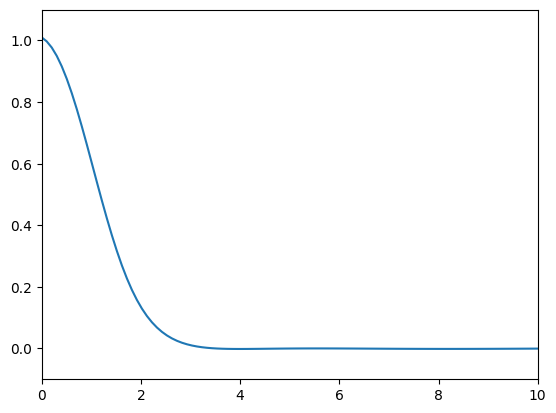

In [9]:
fig, ax = plt.subplots()
ax.grid(True)

def animate(i):
    plt.cla()
    plt.plot(x_plot, fun[i*BATCH_SIZE : (i+1)*BATCH_SIZE])
    plt.xlim(X_DOMAIN[0], X_DOMAIN[1])  
    plt.ylim(-0.1,1.1)

matplotlib.animation.FuncAnimation(fig, animate, frames=BATCH_SIZE)

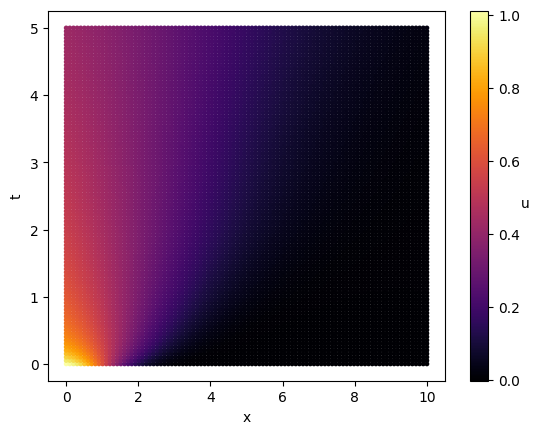

In [13]:
plt.scatter(X_pred, T_pred, c=fun, s=6, cmap='inferno')
plt.xlabel('x')
plt.ylabel('t')
cbar = plt.colorbar()
cbar.set_label('u', rotation=0)
plt.show()